In [16]:
import sys
sys.path.append('..')

In [23]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from dataclasses import dataclass
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import List, Tuple, Dict
from PIL import Image
from CommonFunctions import *
%matplotlib inline

In [18]:
data_path = Path('./data/')
train_data = datasets.CIFAR10(root=data_path, 
                              train=True, 
                              download=True, 
                              transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root=data_path, 
                             train=False,
                             download=True, 
                             transform=transforms.ToTensor())
len(train_data), len(test_data)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [19]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [20]:
train_data[0][0].shape

torch.Size([3, 32, 32])

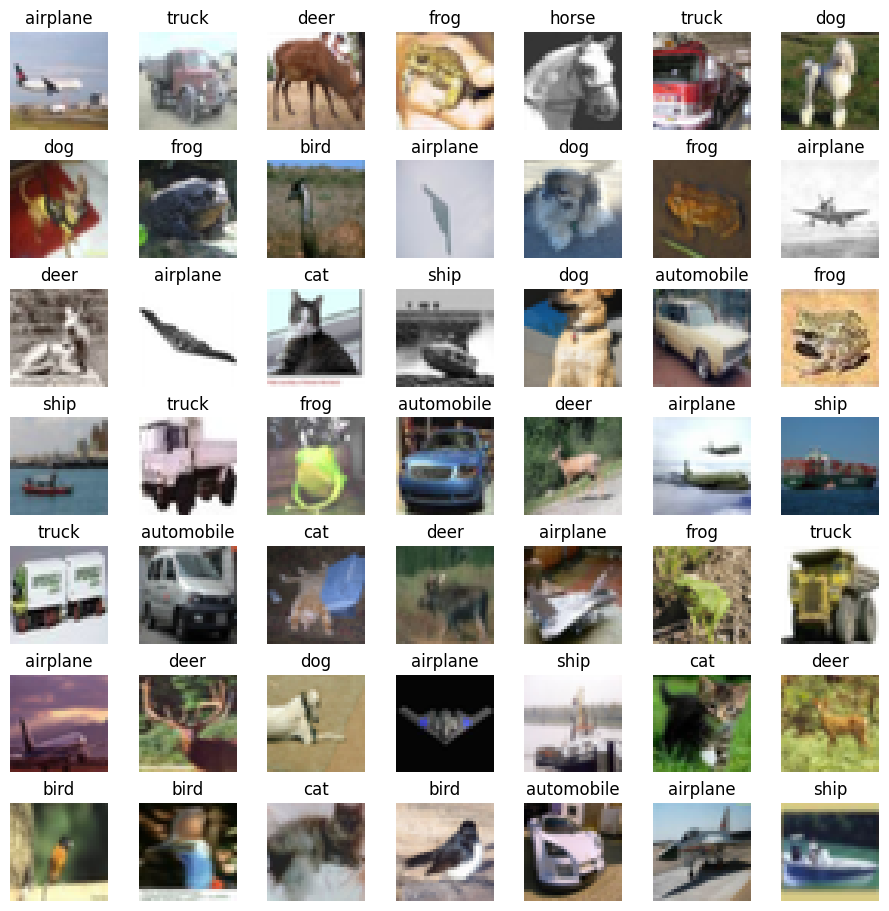

In [22]:
def plot_random_images(dataset, shape, dataset_labels):
    figure, axes = plt.subplots(*shape, layout='constrained', figsize=(9, 9))
    for index, ax in enumerate(figure.axes):
        random_idx = torch.randint(0, len(dataset), size=[1]).item()
        img, lab = dataset[random_idx]
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.set(title=dataset_labels[lab])
        ax.axis(False)
plot_random_images(train_data, (7, 7), classes)

# Defining modular VGG models

In [24]:
class ModularVGG(nn.Module):
    """
    VGG model that can be extended freely
    """
    def __init__(self, input_layer_size: int, num_of_classes: int, image_size: int, config: Dict):
        super(ModularVGG, self).__init__()
        self.latest_layer_size = input_layer_size
        self.image_size = image_size
        
        self.conv_layer = nn.Sequential(
            *self._conv_layers(**config['CONV']),
            nn.Flatten()
        )
        
        self.classifier = nn.Sequential(
            *self._linear_layers(**config['FC']),
            nn.Linear(in_features=self.latest_layer_size,
                      out_features=num_of_classes),
            nn.Softmax(dim=1)
        )
        
    def _conv_layers(self, conv_layers: List[List[int]],
                           kernel_params: Dict,
                           batch_norm: bool = False,
                           activation: nn.Module = nn.ReLU(inplace=True)) -> List[nn.Module]:
        layers = []
        for conv_layer in conv_layers:
            for out_channels in conv_layer:
                layers += [nn.Conv2d(in_channels=self.latest_layer_size,
                                     out_channels=out_channels, **kernel_params), activation]
                self.latest_layer_size = out_channels
            layers += [nn.MaxPool2d(kernel_size=2)]
            layers += [nn.BatchNorm2d(num_features=self.latest_layer_size)] if batch_norm else []
        self.latest_layer_size = (self.image_size // 2**len(conv_layers))**2 * self.latest_layer_size
        return layers
                
    
    def _linear_layers(self, layer_sizes: List[int],
                             dropout: float = 0.,
                             activation: nn.Module = nn.ReLU(inplace=True)) -> List[nn.Module]:
        layers = []
        for layer_size in layer_sizes:
            layers += [nn.Dropout(p=dropout, inplace=True)] if dropout > 0 else []
            layers += [nn.Linear(in_features=self.latest_layer_size,
                                 out_features=layer_size), activation]
            self.latest_layer_size = layer_size
        return layers

In [31]:
@dataclass
class LearningParameters:
    batch_size: int = 64
    cpu_count: int = os.cpu_count()
    learning_rate: float = 0.01
    momentum: float = 0.97
    weight_decay: float = 0.0001
    epochs: int = 150
    device: torch.device = torch.device('cpu')
    dropout: float = 0.
    batch_norm: bool = False
PARAMS = LearningParameters()

KERNEL_PARAMS = dict(kernel_size=3, stride=1, padding=1)
vgg_cfg = dict(
    vgg11=dict(
        CONV=dict(
            conv_layers=[[64],
                         [128],
                         [256, 256],
                         [512, 512],
                         [512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    ),
    vgg13=dict(
        CONV=dict(
            conv_layers=[[64, 64],
                         [128, 128],
                         [256, 256],
                         [512, 512],
                         [512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    ),
    vgg16=dict(
        CONV=dict(
            conv_layers=[[64, 64],
                         [128, 128],
                         [256, 256, 256],
                         [512, 512, 512],
                         [512, 512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    ),
    vgg19=dict(
        CONV=dict(
            conv_layers=[[64, 64],
                         [128, 128],
                         [256, 256, 256, 256],
                         [512, 512, 512, 512],
                         [512, 512, 512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_size=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    ),
    vgg22=dict(
        CONV=dict(
            conv_layers=[[64, 64],
                         [128, 128],
                         [256, 256, 256, 256, 256],
                         [512, 512, 512, 512, 512],
                         [512, 512, 512, 512, 512]],
            kernel_params=KERNEL_PARAMS,
            batch_norm=PARAMS.batch_norm
        ),
        FC=dict(
            layer_sizes=[4096, 4096, 1000],
            dropout=PARAMS.dropout
        )
    ) 
)
model = ModularVGG(input_layer_size=3,
                   num_of_classes=10,
                   image_size=32,
                   config=vgg_cfg['vgg22'])
model

ModularVGG(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1,